In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#statistic
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Ignore FutureWarning warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

### input data

In [2]:
df=pd.read_csv('/Users/candicewu/Desktop/cleaned_dataset.csv')
df.head(3)

,price_log,city,condition,grade,floors,bedrooms,bathrooms,sqft_living_log,sqft_lot_log,house_age,school_rate,unemployment_rate,travel_time_to_work,total_population,typical_levy_rate,median_age,median_household_income,area_crime
0,5.640978,Issaquah,4,9,2.0,3,2.25,3.294466,4.545307,46,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
1,5.799341,Issaquah,3,9,2.0,4,2.75,3.432969,4.571441,23,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
2,5.579646,Issaquah,4,7,1.0,3,2.50,3.217484,4.147800,37,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20552 entries, 0 to 20551
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price_log                20552 non-null  float64
 1   city                     20552 non-null  object 
 2   condition                20552 non-null  int64  
 3   grade                    20552 non-null  int64  
 4   floors                   20552 non-null  float64
 5   bedrooms                 20552 non-null  int64  
 6   bathrooms                20552 non-null  float64
 7   sqft_living_log          20552 non-null  float64
 8   sqft_lot_log             20552 non-null  float64
 9   house_age                20552 non-null  int64  
 10  school_rate              20552 non-null  float64
 11  unemployment_rate        20552 non-null  float64
 12  travel_time_to_work      20552 non-null  float64
 13  total_population         20552 non-null  float64
 14  typical_levy_rate     

### MLR Method


https://medium.com/codex/step-by-step-guide-to-simple-and-multiple-linear-regression-in-python-867ac9a30298

#### Inner Factors

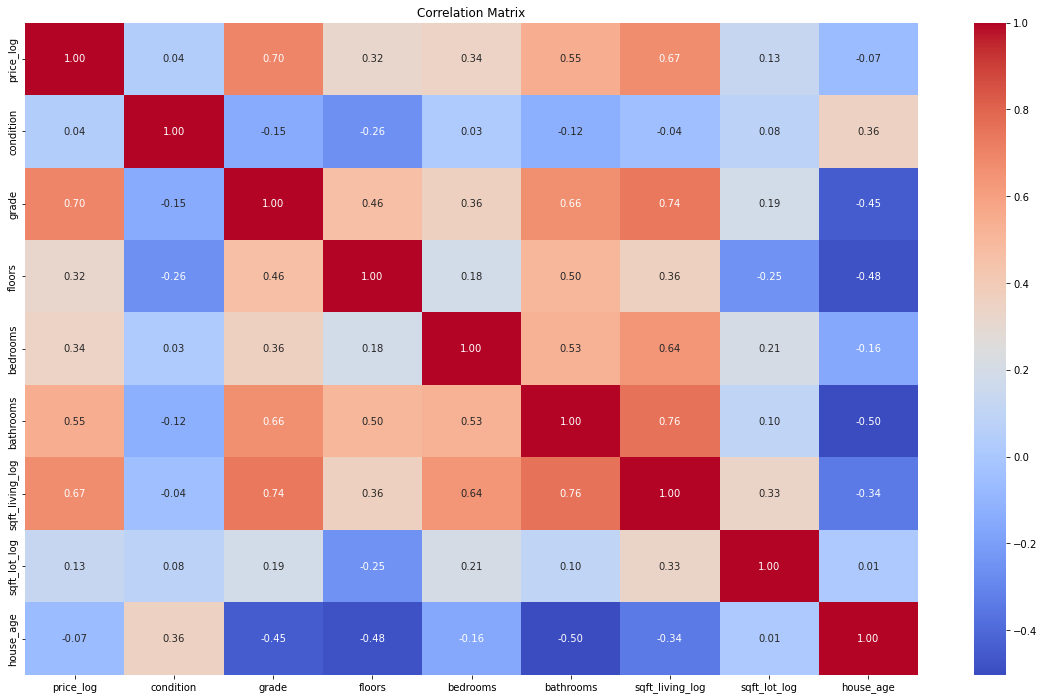

In [4]:
# Displaying correlation matrix with a heatmap
features = df[['price_log','condition','grade','floors', 'bedrooms', 'bathrooms', 
       'sqft_living_log', 'sqft_lot_log', 'house_age']]
corr = features.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

print(vif_data)

           feature          VIF
0        price_log   970.825285
1        condition    33.652694
2            grade   112.974784
3           floors    15.487250
4         bedrooms    26.321093
5        bathrooms    22.723553
6  sqft_living_log  1275.338168
7     sqft_lot_log   147.107310
8        house_age     7.939095


##### 1. OLS model

In [6]:
X = df[['condition','grade','floors', 'bedrooms', 'bathrooms', 
       'sqft_living_log', 'sqft_lot_log', 'house_age']]
y = df['price_log']

# Add intercept term
X = sm.add_constant(X)

# Fit model
model1 = sm.OLS(y, X).fit()

# Print summary
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     4537.
Date:                Fri, 15 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:11:01   Log-Likelihood:                 11764.
No. Observations:               20552   AIC:                        -2.351e+04
Df Residuals:                   20543   BIC:                        -2.344e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.3432      0.027    1

##### Regression Diagnostics

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


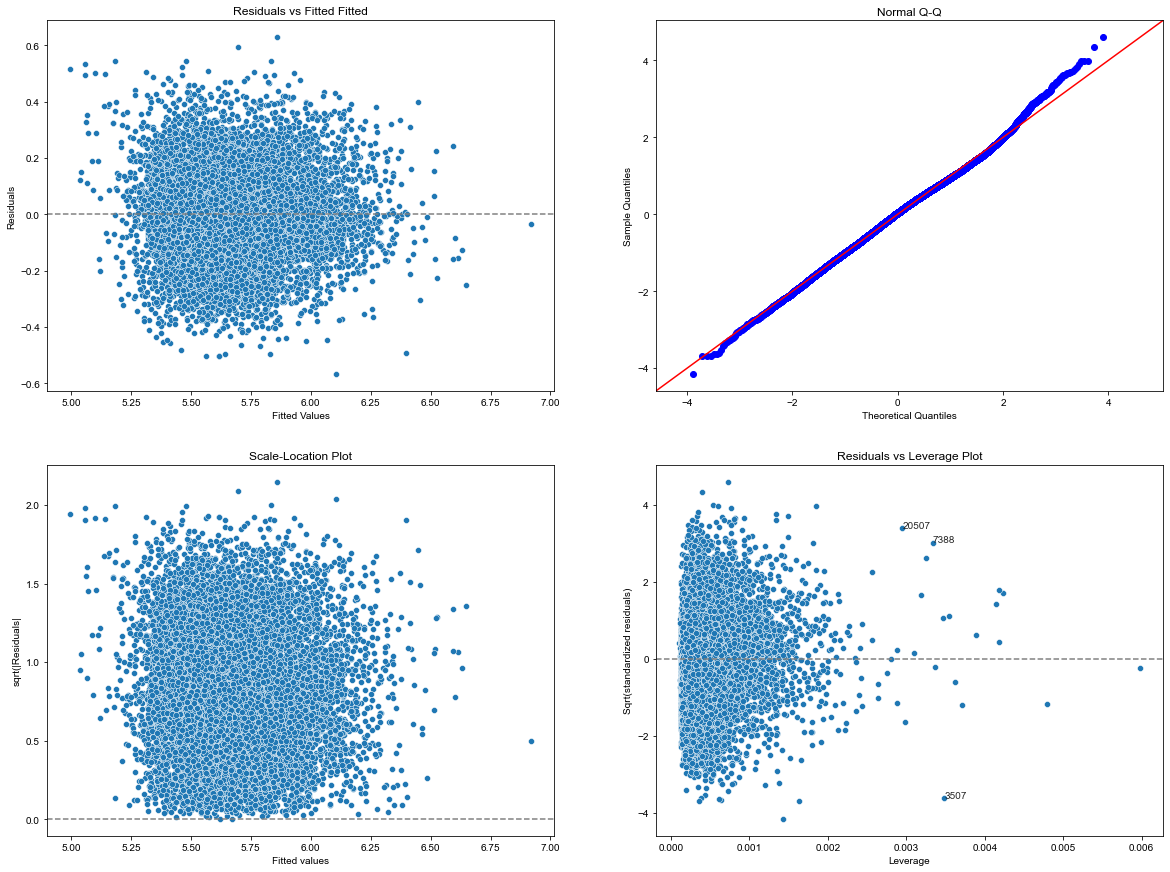

In [7]:
# Get different Variables for diagnostic
fitted_value = model1.fittedvalues #model values
residuals = model1.resid #model residuals
stand_residuals = model1.get_influence().resid_studentized_internal #standardized residuals
stand_residuals_abs_sqrt = np.sqrt(np.abs(stand_residuals)) #absolute squared standardized residuals
abs_resid = np.abs(residuals) #absolute residuals
influence = model1.get_influence()
leverage = influence.hat_matrix_diag #leverage, from statmodels intervals
cooks_distance= model1.get_influence().cooks_distance[0]

# Plot different diagnostic plots
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2)

sns.set_style('whitegrid')

# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted Fitted')

# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45', ax=ax[0, 1])
ax[0, 1].set_title('Normal Q-Q')

# Scale-Location Plot
#https://www.statology.org/scale-location-plot/
#A scale-location plot is a type of plot that displays the fitted values of a regression model along the x-axis and the the square root of the standardized residuals along the y-axis.
sns.scatterplot(x=fitted_value, y=stand_residuals_abs_sqrt, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('sqrt(|Residuals|')
ax[1, 0].set_title('Scale-Location Plot')

# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_residuals, ax=ax[1, 1])
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Residuals vs Leverage Plot')
# annotations
leverage_top_3 = np.flip(np.argsort(cooks_distance), 0)[:3]
for i in leverage_top_3:
   ax[1, 1].annotate(i, xy=(leverage[i], stand_residuals[i]))
    
plt.show()


##### 2.Scikit-learn

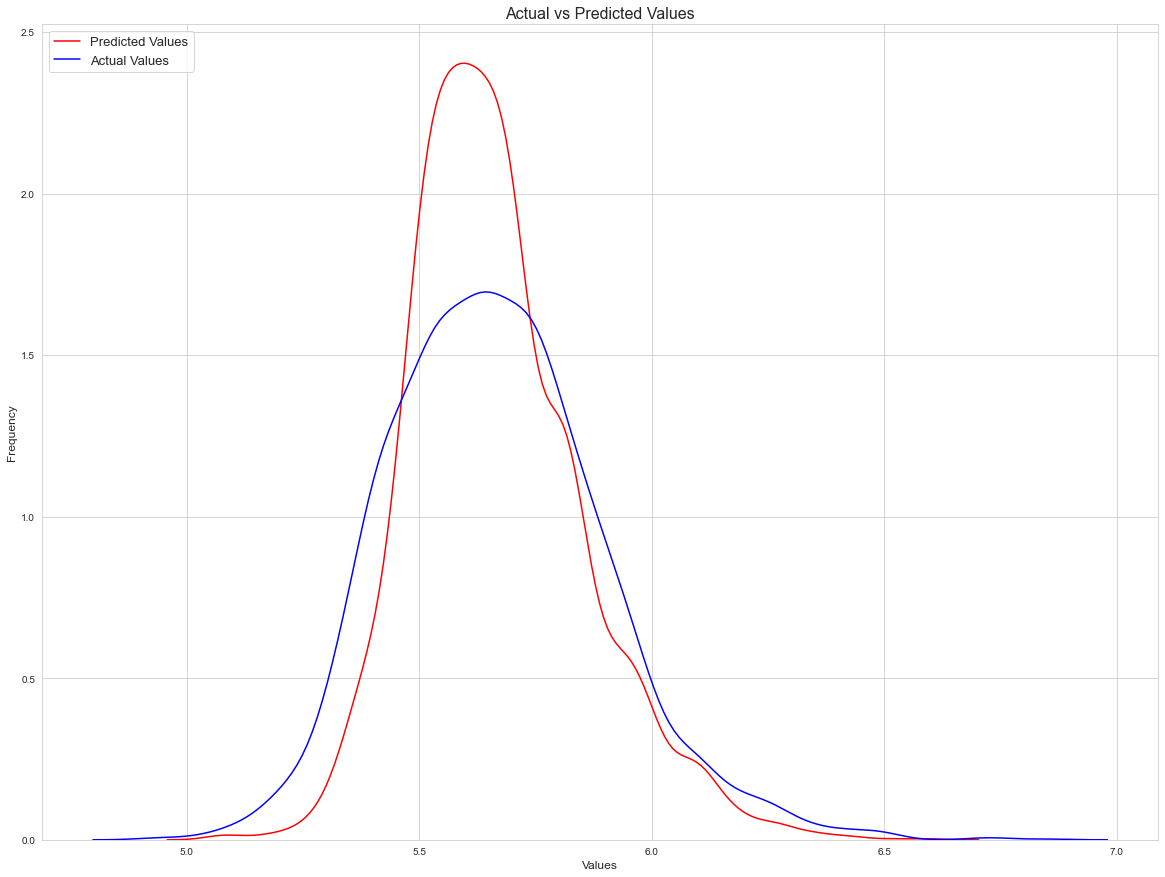

In [8]:
#check the accuracy of the MLR scikit-learn model is by constructing a distribution plot by combining the predicted values and the actual values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred= lr.predict(X_test)

# Visualizing Prediction Accuracy
sns.kdeplot(y_pred, color = 'r', label = 'Predicted Values')
sns.kdeplot(y_test, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

In [9]:
#https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))
print('R-Squared :', r2_score(y_test, y_pred))#https://www.rasgoml.com/feature-engineering-tutorials/how-to-calculate-r-2-with-scikit-learn

MAE:  0.10871002486621657
MSE:  0.018717823882639328
RMSE:  0.32971203324449133
R-Squared : 0.6484430063966262


##### 3. model improvement


In [10]:
#Determine the threshold
threshold = 4 / (len(df) - len(X.columns) - 1)
#any data point with a Cook’s Distance greater than 4/n (where n is the total number of observations) is flagged 
# as an ‘observation of interest’ that is worthy of closer scrutiny.

#Identify outliers
outlier_indices = np.where(cooks_distance > threshold)[0]

#Remove outliers
df_cleaned = df.reset_index(drop=True).drop(outlier_indices)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19458 entries, 0 to 20548
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price_log                19458 non-null  float64
 1   city                     19458 non-null  object 
 2   condition                19458 non-null  int64  
 3   grade                    19458 non-null  int64  
 4   floors                   19458 non-null  float64
 5   bedrooms                 19458 non-null  int64  
 6   bathrooms                19458 non-null  float64
 7   sqft_living_log          19458 non-null  float64
 8   sqft_lot_log             19458 non-null  float64
 9   house_age                19458 non-null  int64  
 10  school_rate              19458 non-null  float64
 11  unemployment_rate        19458 non-null  float64
 12  travel_time_to_work      19458 non-null  float64
 13  total_population         19458 non-null  float64
 14  typical_levy_rate     

In [11]:
X_cleaned = df_cleaned[['condition','grade','floors', 'bedrooms', 'bathrooms',
       'sqft_living_log', 'sqft_lot_log', 'house_age']]
y_cleaned = df_cleaned['price_log']

# Add intercept term
X_cleaned = sm.add_constant(X_cleaned)

# Fit model
cleaned_model1 = sm.OLS(y_cleaned, X_cleaned).fit()

# Print summary
print(cleaned_model1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     5159.
Date:                Fri, 15 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:11:18   Log-Likelihood:                 13742.
No. Observations:               19458   AIC:                        -2.747e+04
Df Residuals:                   19449   BIC:                        -2.739e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.4033      0.024    1

In [12]:
#check the accuracy of the MLR scikit-learn model is by constructing a distribution plot by combining the predicted values and the actual values
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size = 0.2, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred= lr.predict(X_test)

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))
print('R-Squared :', r2_score(y_test, y_pred))

MAE:  0.0970648976282804
MSE:  0.014036738578318482
RMSE:  0.31155239949048763
R-Squared : 0.6878429087838938


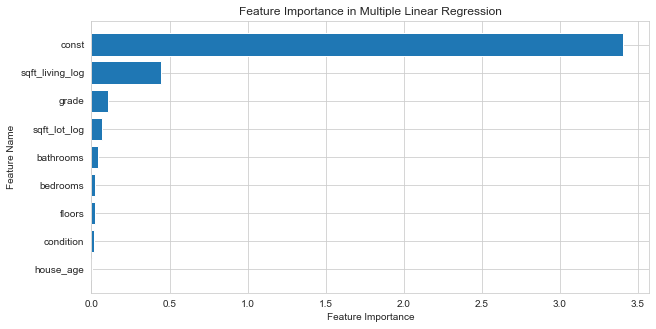

In [13]:
# Get the coefficients (feature importances)
coefficients = cleaned_model1.params

# Take the absolute values of the coefficients as feature importances
feature_importances = np.abs(coefficients)

# Get feature names
feature_names = coefficients.index.tolist()

# Create a DataFrame to hold the feature names and their importances
fi = pd.DataFrame({'Feature Name': feature_names, 'Feature Importance': feature_importances})

# Sort the DataFrame by feature importance in ascending order
fi = fi.sort_values(by='Feature Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.barh(fi['Feature Name'], fi['Feature Importance'])
plt.ylabel("Feature Name")
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Multiple Linear Regression")
plt.show()


#### External Factors

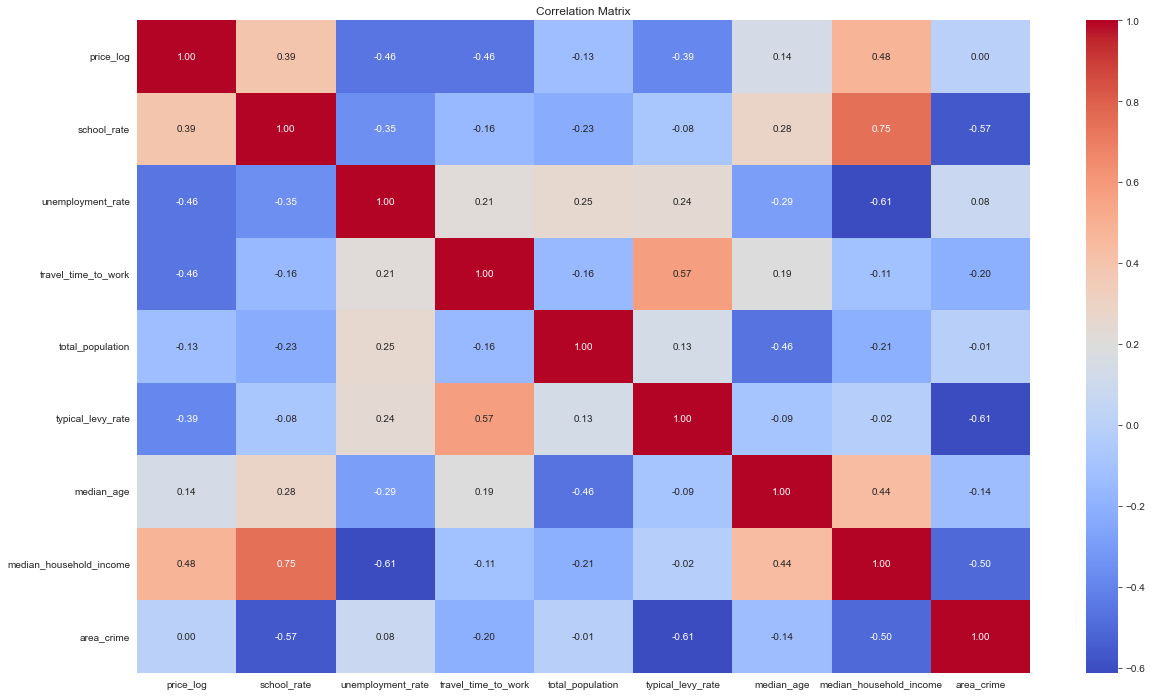

In [14]:
# Displaying correlation matrix with a heatmap
features = df[['price_log','school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
corr = features.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Correlation Matrix')
plt.show()

In [15]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

print(vif_data)

                   feature         VIF
0                price_log  312.602197
1              school_rate   47.735899
2        unemployment_rate   26.390551
3      travel_time_to_work  135.750885
4         total_population   12.655183
5        typical_levy_rate  119.186482
6               median_age  187.367286
7  median_household_income   52.254925
8               area_crime    8.219300


##### 1. OLS model

In [16]:
X = df[['school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
y = df['price_log']

# Add intercept term
X = sm.add_constant(X)

# Fit model
model2 = sm.OLS(y, X).fit()

# Print summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     2056.
Date:                Fri, 15 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:11:31   Log-Likelihood:                 7351.2
No. Observations:               20552   AIC:                        -1.468e+04
Df Residuals:                   20543   BIC:                        -1.461e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

##### Regression Diagnostics

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


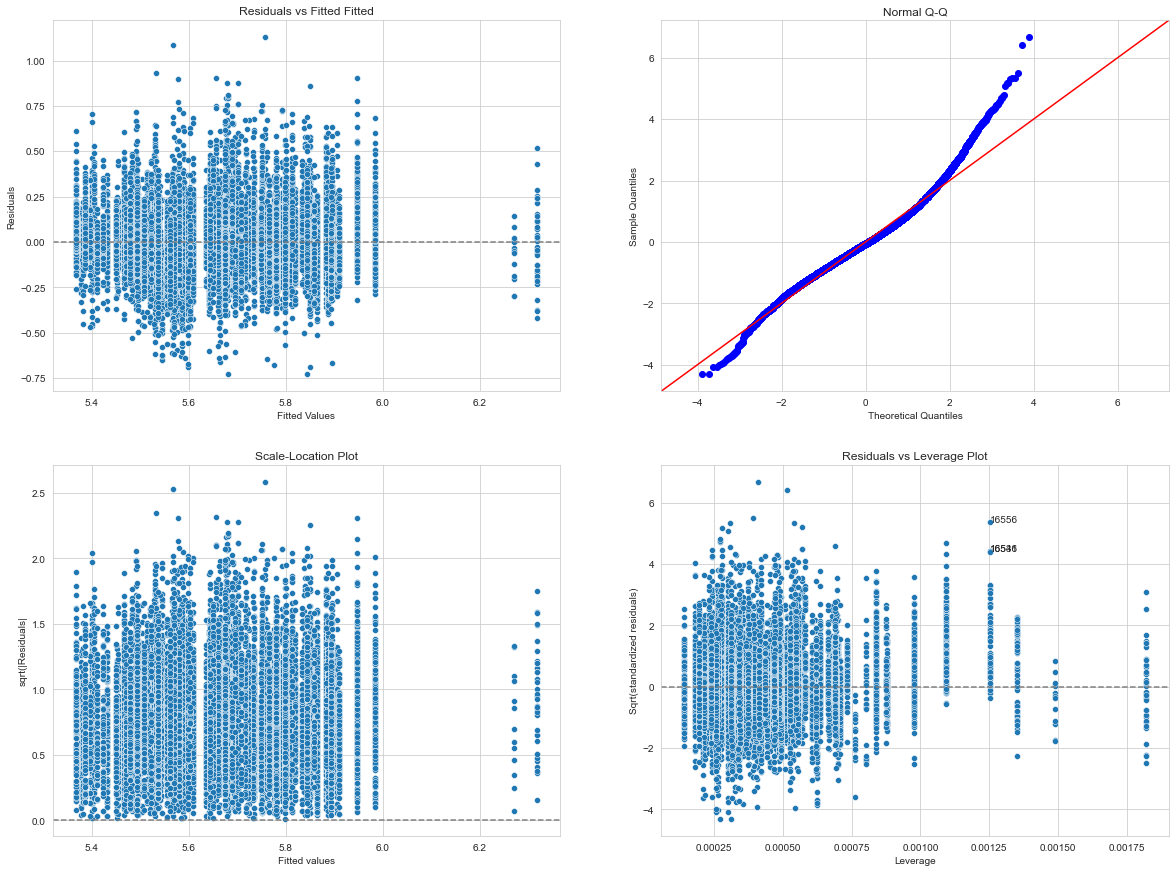

In [17]:
# Get different Variables for diagnostic
fitted_value = model2.fittedvalues #model values
residuals = model2.resid #model residuals
stand_residuals = model2.get_influence().resid_studentized_internal #standardized residuals
stand_residuals_abs_sqrt = np.sqrt(np.abs(stand_residuals)) #absolute squared standardized residuals
abs_resid = np.abs(residuals) #absolute residuals
influence = model2.get_influence()
leverage = influence.hat_matrix_diag #leverage, from statmodels intervals
cooks_distance= model2.get_influence().cooks_distance[0]

# Plot different diagnostic plots
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2)

sns.set_style('whitegrid')

# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted Fitted')

# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45', ax=ax[0, 1])
ax[0, 1].set_title('Normal Q-Q')

# Scale-Location Plot
#https://www.statology.org/scale-location-plot/
#A scale-location plot is a type of plot that displays the fitted values of a regression model along the x-axis and the the square root of the standardized residuals along the y-axis.
sns.scatterplot(x=fitted_value, y=stand_residuals_abs_sqrt, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('sqrt(|Residuals|')
ax[1, 0].set_title('Scale-Location Plot')

# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_residuals, ax=ax[1, 1])
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Residuals vs Leverage Plot')
# annotations
leverage_top_3 = np.flip(np.argsort(cooks_distance), 0)[:3]
for i in leverage_top_3:
   ax[1, 1].annotate(i, xy=(leverage[i], stand_residuals[i]))
    
plt.show()


##### 2.Scikit-learn

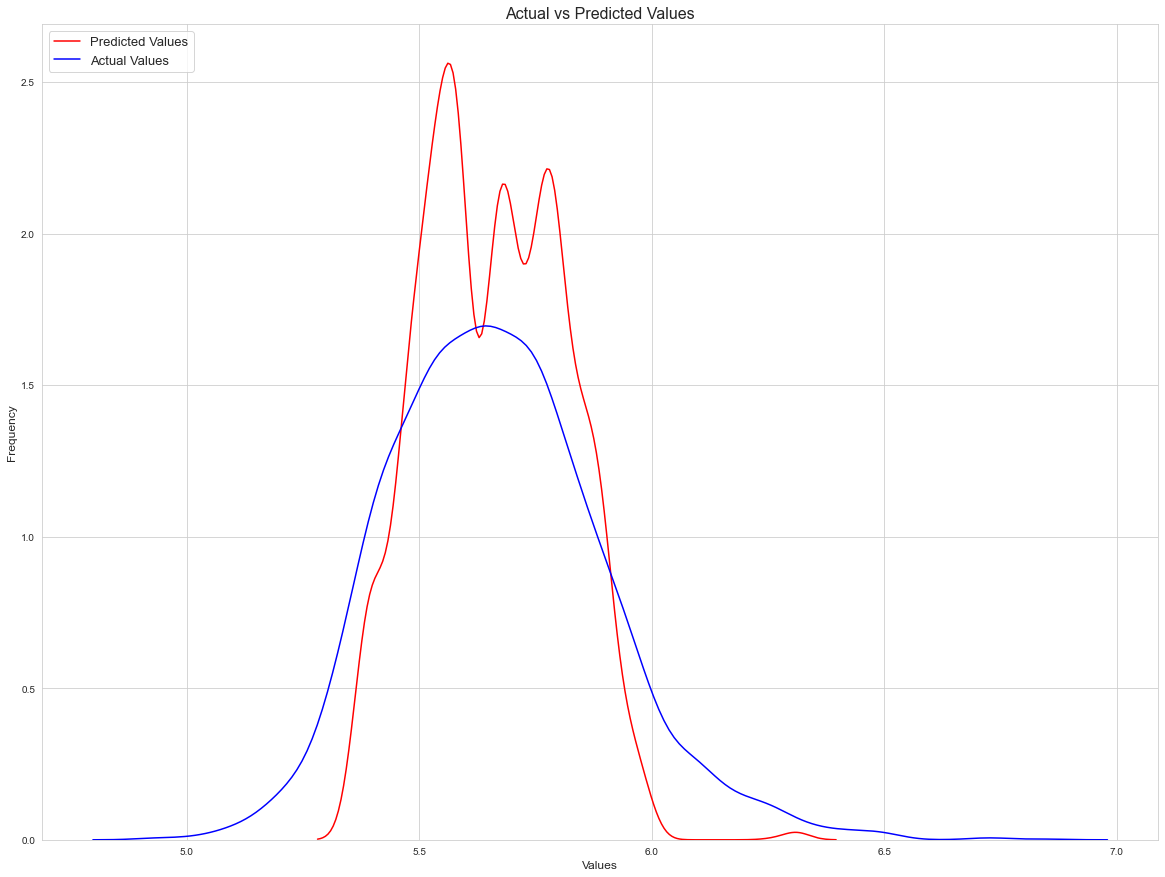

In [18]:
#check the accuracy of the MLR scikit-learn model is by constructing a distribution plot by combining the predicted values and the actual values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred= lr.predict(X_test)

# Visualizing Prediction Accuracy
sns.kdeplot(y_pred, color = 'r', label = 'Predicted Values')
sns.kdeplot(y_test, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

In [19]:

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))
print('R-Squared :', r2_score(y_test, y_pred))

MAE:  0.1279653818272373
MSE:  0.02886153236454905
RMSE:  0.35772249276113083
R-Squared : 0.4579245102162687


##### 3. model improvement


In [20]:
#Determine the threshold
threshold = 4 / (len(df) - len(X.columns) - 1)

#Identify outliers
outlier_indices = np.where(cooks_distance > threshold)[0]

#Remove outliers
df_cleaned = df.reset_index(drop=True).drop(outlier_indices)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19455 entries, 0 to 20551
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price_log                19455 non-null  float64
 1   city                     19455 non-null  object 
 2   condition                19455 non-null  int64  
 3   grade                    19455 non-null  int64  
 4   floors                   19455 non-null  float64
 5   bedrooms                 19455 non-null  int64  
 6   bathrooms                19455 non-null  float64
 7   sqft_living_log          19455 non-null  float64
 8   sqft_lot_log             19455 non-null  float64
 9   house_age                19455 non-null  int64  
 10  school_rate              19455 non-null  float64
 11  unemployment_rate        19455 non-null  float64
 12  travel_time_to_work      19455 non-null  float64
 13  total_population         19455 non-null  float64
 14  typical_levy_rate     

In [21]:
X_cleaned = df_cleaned[[ 'school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
y_cleaned = df_cleaned['price_log']

# Add intercept term
X_cleaned = sm.add_constant(X_cleaned)

# Fit model
cleaned_model2 = sm.OLS(y_cleaned, X_cleaned).fit()

# Print summary
print(cleaned_model2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     2726.
Date:                Fri, 15 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:11:47   Log-Likelihood:                 10898.
No. Observations:               19455   AIC:                        -2.178e+04
Df Residuals:                   19446   BIC:                        -2.171e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [22]:
#check the accuracy of the MLR scikit-learn model is by constructing a distribution plot by combining the predicted values and the actual values
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size = 0.2, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred= lr.predict(X_test)

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))
print('R-Squared :', r2_score(y_test, y_pred))

MAE:  0.11054274379068156
MSE:  0.01950818941632038
RMSE:  0.3324796892904611
R-Squared : 0.5280908491533864


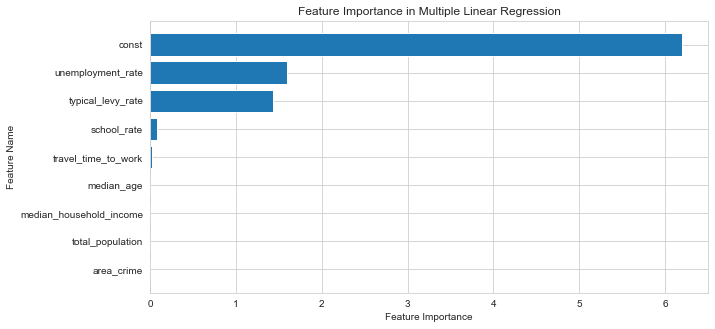

In [23]:
# Get the coefficients (feature importances)
coefficients = cleaned_model2.params

# Take the absolute values of the coefficients as feature importances
feature_importances = np.abs(coefficients)

# Get feature names
feature_names = coefficients.index.tolist()

# Create a DataFrame to hold the feature names and their importances
fi = pd.DataFrame({'Feature Name': feature_names, 'Feature Importance': feature_importances})

# Sort the DataFrame by feature importance in ascending order
fi = fi.sort_values(by='Feature Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.barh(fi['Feature Name'], fi['Feature Importance'])
plt.ylabel("Feature Name")
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Multiple Linear Regression")
plt.show()


#### Overall Factors

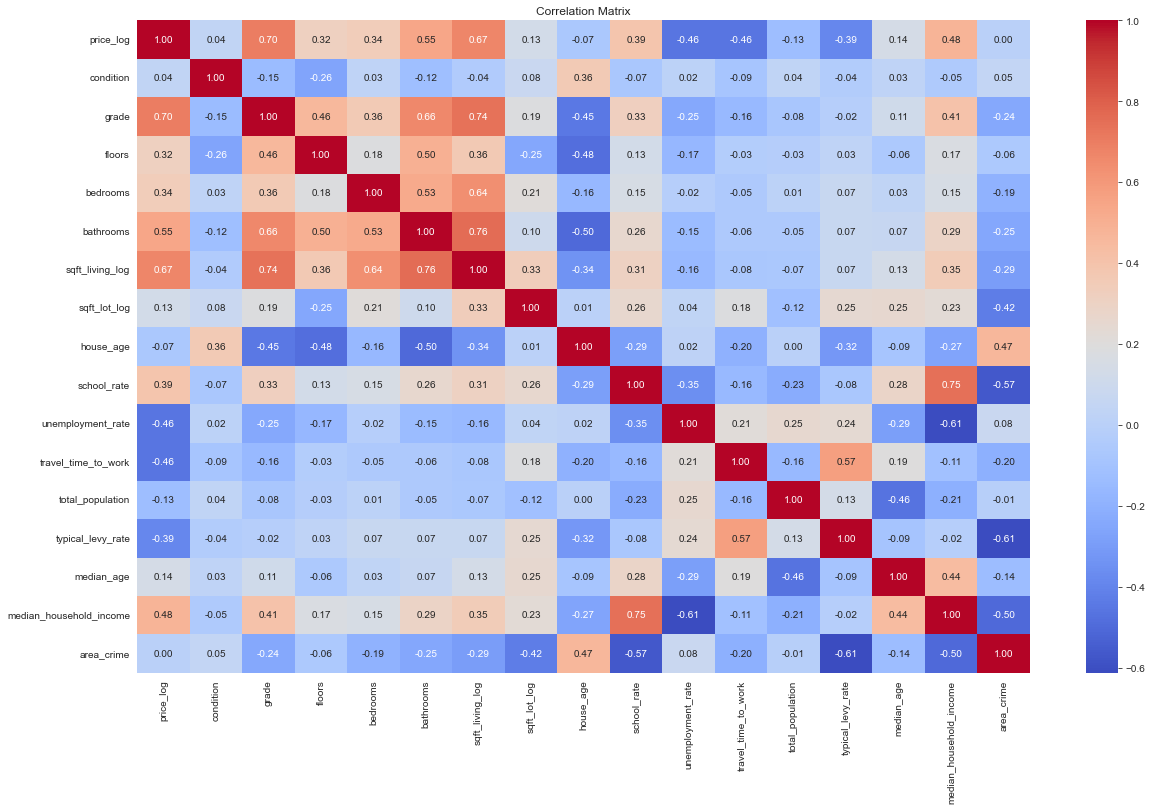

In [24]:
# Displaying correlation matrix with a heatmap
features = df[['price_log','condition','grade','floors', 'bedrooms', 'bathrooms', 
       'sqft_living_log', 'sqft_lot_log', 'house_age', 'school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
corr = features.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

##### 1. OLS model

In [25]:
X = df[['condition','grade','floors', 'bedrooms', 'bathrooms', 
       'sqft_living_log', 'sqft_lot_log', 'house_age', 'school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
y = df['price_log']

# Add intercept term
X = sm.add_constant(X)

# Fit model
model3 = sm.OLS(y, X).fit()

# Print summary
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     5496.
Date:                Fri, 15 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:11:55   Log-Likelihood:                 18409.
No. Observations:               20552   AIC:                        -3.678e+04
Df Residuals:                   20535   BIC:                        -3.665e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

##### Regression Diagnostics
https://www.geeksforgeeks.org/residual-leverage-plot-regression-diagnostic/</p>
https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


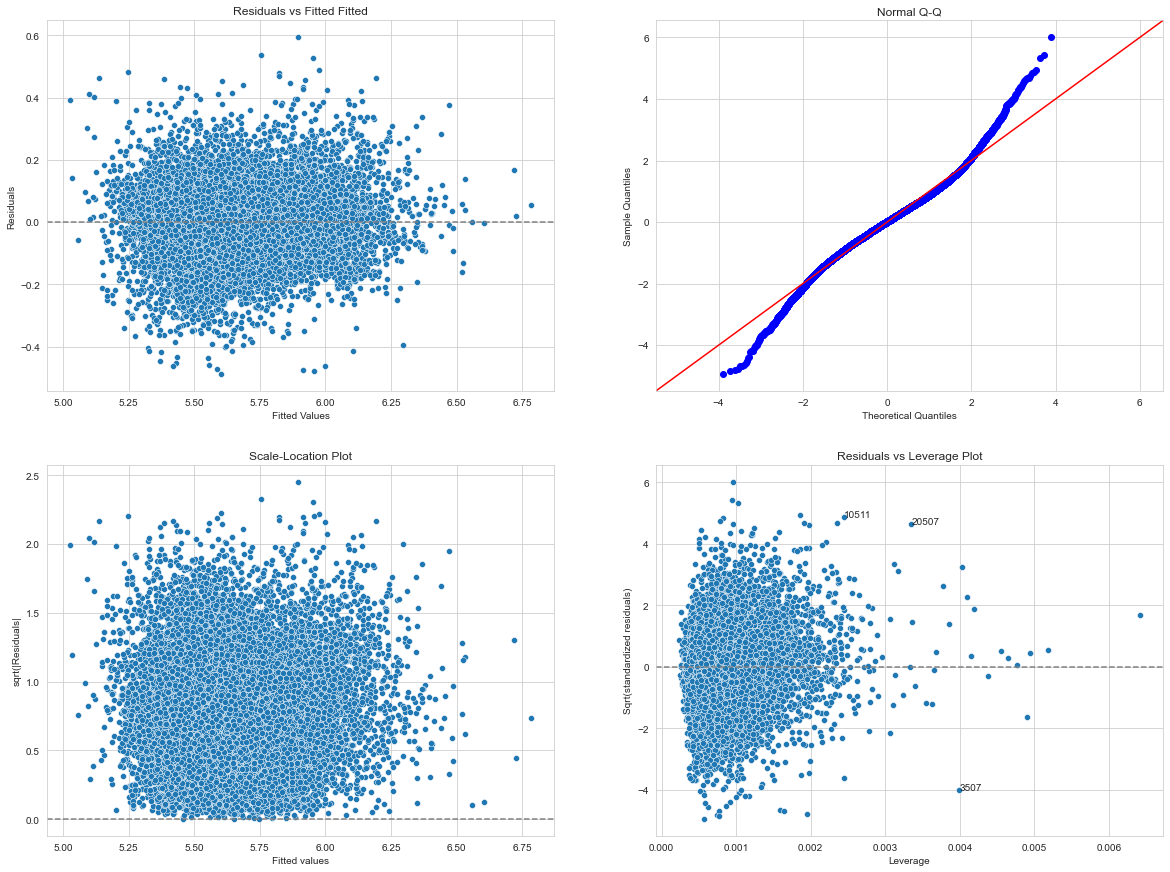

In [26]:
# Get different Variables for diagnostic
fitted_value = model3.fittedvalues #model values
residuals = model3.resid #model residuals
stand_residuals = model3.get_influence().resid_studentized_internal #standardized residuals
stand_residuals_abs_sqrt = np.sqrt(np.abs(stand_residuals)) #absolute squared standardized residuals
abs_resid = np.abs(residuals) #absolute residuals
influence = model3.get_influence()
leverage = influence.hat_matrix_diag #leverage, from statmodels intervals
cooks_distance= model3.get_influence().cooks_distance[0]

# Plot different diagnostic plots
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2)

sns.set_style('whitegrid')

# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted Fitted')

# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45', ax=ax[0, 1])
ax[0, 1].set_title('Normal Q-Q')

# Scale-Location Plot
#https://www.statology.org/scale-location-plot/
#A scale-location plot is a type of plot that displays the fitted values of a regression model along the x-axis and the the square root of the standardized residuals along the y-axis.
sns.scatterplot(x=fitted_value, y=stand_residuals_abs_sqrt, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('sqrt(|Residuals|')
ax[1, 0].set_title('Scale-Location Plot')

# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_residuals, ax=ax[1, 1])
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Residuals vs Leverage Plot')
# annotations
leverage_top_3 = np.flip(np.argsort(cooks_distance), 0)[:3]
for i in leverage_top_3:
   ax[1, 1].annotate(i, xy=(leverage[i], stand_residuals[i]))
    
plt.show()


It’s important to note that Cook’s Distance should be used as a way to identify potentially influential observations. Just because an observation is influential doesn’t necessarily mean that it should be deleted from the dataset.</p>
Therefore, we should verify that the observation isn’t a result of a data entry error or some other odd occurrence. If it turns out to be a legit value, we can then decide if it’s appropriate to delete it, leave it be, or simply replace it with an alternative value like the median.</p>
https://www.statology.org/cooks-distance-python/#:~:text=The%20larger%20the%20value%20for,considered%20to%20be%20highly%20influential.

##### 2.Scikit-learn

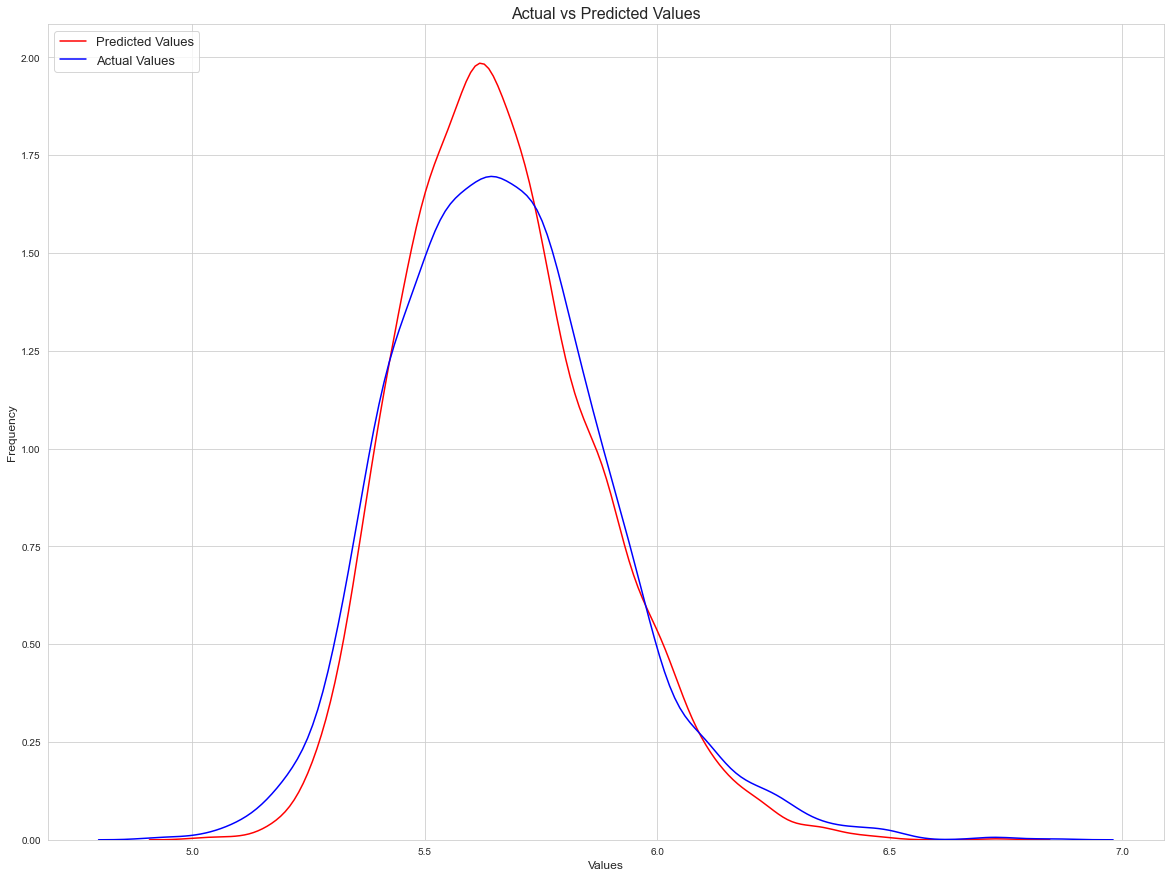

In [27]:
#check the accuracy of the MLR scikit-learn model is by constructing a distribution plot by combining the predicted values and the actual values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred= lr.predict(X_test)

# Visualizing Prediction Accuracy
sns.kdeplot(y_pred, color = 'r', label = 'Predicted Values')
sns.kdeplot(y_test, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

In [28]:
#https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))
print('R-Squared :', r2_score(y_test, y_pred))#https://www.rasgoml.com/feature-engineering-tutorials/how-to-calculate-r-2-with-scikit-learn

MAE:  0.07302550715037111
MSE:  0.009587719810829034
RMSE:  0.27023232069900727
R-Squared : 0.8199240481510885


##### 3. model improvement
https://towardsdatascience.com/identifying-outliers-in-linear-regression-cooks-distance-9e212e9136a

In [29]:
#Determine the threshold
threshold = 4 / (len(df) - len(X.columns) - 1)
#any data point with a Cook’s Distance greater than 4/n (where n is the total number of observations) is flagged 
# as an ‘observation of interest’ that is worthy of closer scrutiny.

#Identify outliers
outlier_indices = np.where(cooks_distance > threshold)[0]

#Remove outliers
df_cleaned = df.reset_index(drop=True).drop(outlier_indices)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19285 entries, 0 to 20551
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price_log                19285 non-null  float64
 1   city                     19285 non-null  object 
 2   condition                19285 non-null  int64  
 3   grade                    19285 non-null  int64  
 4   floors                   19285 non-null  float64
 5   bedrooms                 19285 non-null  int64  
 6   bathrooms                19285 non-null  float64
 7   sqft_living_log          19285 non-null  float64
 8   sqft_lot_log             19285 non-null  float64
 9   house_age                19285 non-null  int64  
 10  school_rate              19285 non-null  float64
 11  unemployment_rate        19285 non-null  float64
 12  travel_time_to_work      19285 non-null  float64
 13  total_population         19285 non-null  float64
 14  typical_levy_rate     

In [30]:
X_cleaned = df_cleaned[['condition','grade','floors','bedrooms', 'bathrooms',
       'sqft_living_log', 'sqft_lot_log', 'house_age', 'school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
y_cleaned = df_cleaned['price_log']

# Add intercept term
X_cleaned = sm.add_constant(X_cleaned)

# Fit model
cleaned_model3 = sm.OLS(y_cleaned, X_cleaned).fit()

# Print summary
print(cleaned_model3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     7416.
Date:                Fri, 15 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:12:00   Log-Likelihood:                 21756.
No. Observations:               19285   AIC:                        -4.348e+04
Df Residuals:                   19268   BIC:                        -4.334e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [31]:
#check the accuracy of the MLR scikit-learn model is by constructing a distribution plot by combining the predicted values and the actual values
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size = 0.2, random_state = 0)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred= lr.predict(X_test)

print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))
print('R-Squared :', r2_score(y_test, y_pred))

MAE:  0.06304661708932072
MSE:  0.006115745778264691
RMSE:  0.25109085425264044
R-Squared : 0.865475066640314


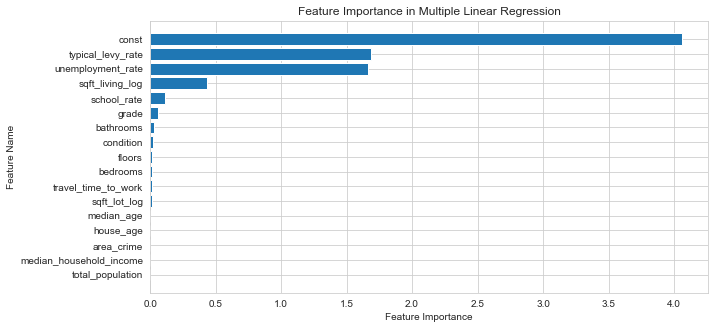

In [32]:
# Get the coefficients (feature importances)
coefficients = cleaned_model3.params

# Take the absolute values of the coefficients as feature importances
feature_importances = np.abs(coefficients)

# Get feature names
feature_names = coefficients.index.tolist()

# Create a DataFrame to hold the feature names and their importances
fi = pd.DataFrame({'Feature Name': feature_names, 'Feature Importance': feature_importances})

# Sort the DataFrame by feature importance in ascending order
fi = fi.sort_values(by='Feature Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 5))
plt.barh(fi['Feature Name'], fi['Feature Importance'])
plt.ylabel("Feature Name")
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Multiple Linear Regression")
plt.show()
